# Kaggle Competition - Trump Tweet Text Classification Project

* **Team Name:** Trump No Thank

* **Team Member:** Sherrie Chen, Wenyuan Ma, Xiangzhou Wang(Dennis), Jialu You, Heather Zhu

* **Kaggle Name:** better music than level b, wm263, Dennis, Jialu You, HZZZ

In [33]:
import numpy as np
import pandas as pd
import csv
import nltk
import re
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

## Data Exploration and Visualization

In [3]:
testdf = pd.read_csv('test.csv')
traindf = pd.read_csv('train.csv')


In [4]:
n, d = traindf.shape
print("There are {} observations and {} features in this dataset. \n".format(n,d))

There are 1089 observations and 18 features in this dataset. 



   label                                               text
0     -1  Senior United States District Judge Robert E. ...
1      1  I heard that the underachieving John King of @...
There are 77141 words in the combination of all review.


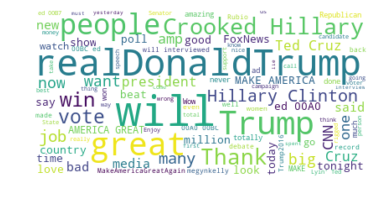

In [5]:
df = traindf.groupby('label')['text'].apply(' '.join).reset_index()
print(df)
trump = str(df['text'][1])
print ("There are {} words in the combination of all review.".format(len(trump)))

stopwords = set(STOPWORDS)
stopwords.update(['https','name','co', 'the', 'in', 'on'])

wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords = stopwords, background_color="white").generate(trump)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("Trump Word Cloud.png")

**Above is the word cloud for all Trump's posts**

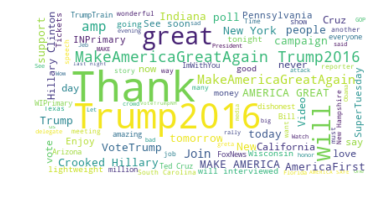

In [6]:
not_trump = str(df['text'][0])

wordcloud = WordCloud(max_font_size=50, max_words=100,  stopwords = stopwords,background_color="white").generate(not_trump)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("Not Trump Word Cloud.png")

**Above is the word cloud for all Non-Trump's posts**

## Data Preprocess

* load as ordered dictionary for faster data processing

In [7]:
def preprocess():
    '''“”“
    load data as dict
    ”“”'''
    train_reader = csv.DictReader(open('train.csv', 'rt'))
    train_dict_list = []
    for line in train_reader:
        train_dict_list.append(line)
    test_reader = csv.DictReader(open('test.csv', 'rt'))
    test_dict_list = []
    for line in test_reader:
        test_dict_list.append(line)
    return train_dict_list, test_dict_list

In [8]:
train_dict_list, test_dict_list = preprocess()

In [9]:
train_dict_list[0]

OrderedDict([('id', '7.52668E+17'),
             ('text',
              'Senior United States District Judge Robert E. Payne today ruled in favor of Trump campaign delegates who had argued..https://t.co/qVwfjgCHU7'),
             ('favorited', 'FALSE'),
             ('favoriteCount', '14207'),
             ('replyToSN', 'NA'),
             ('created', '7/12/16 0:56'),
             ('truncated', 'FALSE'),
             ('replyToSID', 'NA'),
             ('replyToUID', 'NA'),
             ('statusSource',
              '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'),
             ('screenName', 'realDonaldTrump'),
             ('retweetCount', '5256'),
             ('isRetweet', 'FALSE'),
             ('retweeted', 'FALSE'),
             ('longitude', 'NA'),
             ('latitude', 'NA'),
             ('label', '-1')])

## Feature Selection

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/youjialu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import re
from nltk.corpus import stopwords
def tokenize(text):
    n_text = text.lower()
    return re.findall(r"[A-Za-z]+", n_text)

def tokenize_transcript(tokenize_method,input_transcript):
    texts = []
    for index,row in input_transcript.iterrows():
        texts = texts + tokenize_method(row['text'])
    return texts

def build_word_tweet_count(input_df):
    ndf = input_df.copy()
    ndf['text']= ndf['text'].apply(tokenize)
    word_tweet_count = dict()
    for index,row in ndf.iterrows():
        for word in row['text']:
            if word not in stopwords.words('english'):
                if word in word_tweet_count:
                    word_tweet_count[word].add(index)
                else:
                    word_tweet_count[word]=set()
    for word,value in word_tweet_count.items():
        word_tweet_count[word] = len(value)
    return word_tweet_count
            

def create_word_freq_array(input_df,input_good_types):
    npa = []
    for trump_status in [1,-1]:
        trans = []
        dic = {}
        df = input_df.loc[input_df['label']==trump_status]
        for index,row in df.iterrows():
            trans = trans + tokenize(row['text'])
        row = []
        for t in range(0, len(input_good_types)):
            row.append(trans.count(input_good_types[t]))
        npa.append(row)
    return np.array(npa)

def output_good_types(input_word_counts,n):
    lis = []
    for word in input_word_counts.keys():
        if input_word_counts[word] > n:
            lis.append(word)
    return sorted(lis)

def top_n_words_by_status(input_word_array,
                          input_status_list,
                          input_good_types,
                          input_status,n):
    k = np.zeros(len(input_good_types))
    for g in range(0,len(input_status_list)):
        if input_status_list[g] == input_status:
            k += input_word_array[g]
    ls=k/(input_word_array.sum(axis=0)+np.ones(len(input_good_types)))
    ls_i = np.argsort(ls)[-n:][::-1]
    return [(input_good_types[w],ls[w],k[w]) for w in ls_i]

In [12]:
n_train = traindf[['id','text','label']]
count_dict = build_word_tweet_count(n_train)
good_types = output_good_types(count_dict,35)
word_array = create_word_freq_array(n_train,good_types)


**Top ten words for Trump posts.**

In [13]:
top_n_words_by_status(word_array,
                          [1,-1],
                          good_types,1,10)

[('realdonaldtrump', 0.9834710743801653, 119.0),
 ('win', 0.9111111111111111, 41.0),
 ('u', 0.8832116788321168, 121.0),
 ('president', 0.8571428571428571, 42.0),
 ('big', 0.8478260869565217, 39.0),
 ('bad', 0.8333333333333334, 35.0),
 ('many', 0.8260869565217391, 38.0),
 ('one', 0.8205128205128205, 32.0),
 ('would', 0.813953488372093, 35.0),
 ('ted', 0.7924528301886793, 42.0)]

**Top ten words for Non-Trump posts.**

In [14]:
top_n_words_by_status(word_array,
                          [1,-1],
                          good_types,-1,10)

[('https', 0.8825995807127882, 421.0),
 ('co', 0.8807531380753139, 421.0),
 ('makeamericagreatagain', 0.8282828282828283, 82.0),
 ('thank', 0.7783018867924528, 165.0),
 ('trump', 0.6025236593059937, 191.0),
 ('new', 0.5873015873015873, 37.0),
 ('amp', 0.5492957746478874, 39.0),
 ('america', 0.4794520547945205, 35.0),
 ('today', 0.4523809523809524, 19.0),
 ('tonight', 0.45, 18.0)]

**Select five top words from each and get the top 10 important word features as:**

In [15]:
feature_list = ([x[0] for x in top_n_words_by_status(word_array,[1,-1],good_types,1,5)] + 
                [x[0] for x in top_n_words_by_status(word_array,[1,-1],good_types,-1,5)])
feature_list

['realdonaldtrump',
 'win',
 'u',
 'president',
 'big',
 'https',
 'co',
 'makeamericagreatagain',
 'thank',
 'trump']

## Extract Feature

In [16]:
def extract_features(tweet_dict,Flist):
    '''
    return feature vector indicating whether certain feature is present in each tweet text.
    '''
    feature_vec = {}
    text = tweet_dict['text'].lower()
    feature_vec['has@'] = 1 if '@' in text else 0
    feature_vec['has link'] = 1 if 'https' in text else 0
    feature_vec['has #'] = 1 if '#' in text else 0
    feature_vec['has opponent'] = 1 if 'crooked' or 'hillary' or 'clinton' in text else 0
    feature_vec['favorite'] = tweet_dict['favoriteCount']
    feature_vec['retweet'] = tweet_dict['retweetCount']
    for feature in Flist:
        feature_vec[feature] = 1 if feature in text else 0
    return feature_vec


## Maximum Entropy Classifier Training

In [17]:
def train(dict_lst, FList, m):
    '''
    
    '''
    feature_lst = []
    for i in range(len(dict_lst)):
        tweet = dict_lst[i]
        feature_vec = extract_features(tweet,FList)
        feature_lst.append((feature_vec, tweet['label']))
    max_ent_classifier = nltk.MaxentClassifier.train(feature_lst, 'GIS',max_iter = m)
    return max_ent_classifier

In [31]:
classifier = train(train_dict_list,['realdonaldtrump'],4)

  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.43078        0.959
             3          -0.31313        0.961
         Final          -0.24747        0.994


## Predict

In [24]:
def predict(dict_list, classifier, Flist):
    with open('result.csv', 'w') as f:
        f.write('ID,Label\n')
        num_id = 0
        preds = []
        for i in range(len(dict_list)):
            tweet = dict_list[i]
            feature = extract_features(tweet, Flist)
            pred = classifier.classify(feature)
            preds.append(pred)
            if pred == '+1':
                f.write(str(num_id) + ',1\n')
            else:
                f.write(str(num_id) + ',-1\n')
            num_id += 1
    return preds

## Hyper-Parameter Tuning -- Cross Validation

* \lambda in model calculation (dual form) -- Generalized Iterative Scaling
* number of features in the feature list -- Cross Validation
* iteration number of Max Entropy Classifier-- Cross Validation

In [25]:
#<GRADED>
def cross_validation(Tr, xVal, yVal, FeatureList,IterList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    Error=np.zeros((len(FeatureList),len(IterList)))

    

    for i in range(len(FeatureList)):
         for j in range(len(IterList)):
                F = FeatureList[:i]
                classifier = train(xTr, F,IterList[j])
                pred = predict(xVal, classifier, F)
                pred = list(map(int,pred))
                yVal = list(map(int,yVal))
                Error[i][j]=np.mean(np.sign(pred)!=np.sign(yVal))
    a,b = np.where(Error == Error.min())
    bestF, bestI = FeatureList[:a[0]], IterList[b[0]]
    MinError = Error.min()

    return bestF, bestI, MinError



## 10-Fold CV

* Full Feature List: ['realdonaldtrump', 'win',
 'u',
 'president',
 'big',
 'https',
 'co',
 'makeamericagreatagain',
 'thank',
 'trump']

* Full Iteration List: [3,4,5,6,7,8]


In [26]:
FeatureList = feature_list
IterList = [3,4,5,6,7,8]
n = len(train_dict_list)
i = list(range(n))
random.shuffle(i)
xTr = []
for j in range(n):
    xTr.append(train_dict_list[i[j]])
xTr = np.array(xTr)
yTr = []
for j in range(n):
    yTr.append(xTr[j]['label'])
yTr = np.array(yTr)
xTrain = []
xValid = []
yValid = []

skf = StratifiedKFold(n_splits=10, random_state = None)
for train_index, test_index in skf.split(xTr,yTr):
        X_train, X_test = list(xTr[train_index]), list(xTr[test_index])
        Y_train, Y_test = list(yTr[train_index]), list(yTr[test_index])
        xTrain.append(X_train)
        xValid.append(X_test)
        yValid.append(Y_test)

In [28]:
bestF = np.zeros(len(xTrain))
bestI = np.zeros(len(xTrain))
for k in range(len(xTrain)):
    xTr = xTrain[k]
    xVal = xValid[k]
    yVal = yValid[k]
    F, I, Error = cross_validation(xTr, xVal, yVal, FeatureList, IterList)
    print('for Case', k+1, 'Best Feature List: ', F, 'Best Iter: ', I, 'Error: ', Error)
    bestI[k] = I

  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42369        0.961
         Final          -0.30535        0.962
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42369        0.961
             3          -0.30535        0.962
         Final          -0.24018        0.993
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42369        0.961
             3          -0.30535        0.962
             4          -0.24018        0.993
         Final          -0.19859        0.995
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
  

             2          -0.47250        0.895
             3          -0.35822        0.959
             4          -0.28908        0.981
             5          -0.24293        0.991
             6          -0.20987        0.991
         Final          -0.18494        0.996
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.47250        0.895
             3          -0.35822        0.959
             4          -0.28908        0.981
             5          -0.24293        0.991
             6          -0.20987        0.991
             7          -0.18494        0.996
         Final          -0.16541        0.997
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48626        0.895
         Final    

             1          -0.69315        0.432
             2          -0.48580        0.861
             3          -0.37834        0.877
             4          -0.31316        0.898
         Final          -0.26943        0.899
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48580        0.861
             3          -0.37834        0.877
             4          -0.31316        0.898
             5          -0.26943        0.899
         Final          -0.23774        0.952
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48580        0.861
             3          -0.37834        0.877
             4          -0.31316        0.898
             5          -0.26943        0.899
             6    

             5          -0.19430        0.996
             6          -0.16566        0.999
             7          -0.14440        0.999
         Final          -0.12795        1.000
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42793        0.961
         Final          -0.30975        0.962
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42793        0.961
             3          -0.30975        0.962
         Final          -0.24414        0.995
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42793        0.961
             3          -0.30975 

             1          -0.69315        0.432
             2          -0.48204        0.897
             3          -0.36913        0.958
             4          -0.29934        0.958
             5          -0.25224        0.992
             6          -0.21831        0.992
         Final          -0.19265        0.995
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48204        0.897
             3          -0.36913        0.958
             4          -0.29934        0.958
             5          -0.25224        0.992
             6          -0.21831        0.992
             7          -0.19265        0.995
         Final          -0.17251        0.997
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2    

             2          -0.48898        0.862
             3          -0.38223        0.881
             4          -0.31714        0.901
         Final          -0.27335        0.903
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48898        0.862
             3          -0.38223        0.881
             4          -0.31714        0.901
             5          -0.27335        0.903
         Final          -0.24159        0.946
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48898        0.862
             3          -0.38223        0.881
             4          -0.31714        0.901
             5          -0.27335        0.903
             6          -0.24159        0.946
         Final    

             6          -0.17385        0.997
             7          -0.15211        0.999
         Final          -0.13526        0.999
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.44863        0.955
         Final          -0.33157        0.958
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.44863        0.955
             3          -0.33157        0.958
         Final          -0.26410        0.989
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.44863        0.955
             3          -0.33157        0.958
             4          -0.26410 

             1          -0.69315        0.432
             2          -0.49421        0.895
             3          -0.38402        0.953
             4          -0.31409        0.953
             5          -0.26616        0.986
             6          -0.23132        0.991
         Final          -0.20480        0.992
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49421        0.895
             3          -0.38402        0.953
             4          -0.31409        0.953
             5          -0.26616        0.986
             6          -0.23132        0.991
             7          -0.20480        0.992
         Final          -0.18390        0.996
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2    

             2          -0.49424        0.863
             3          -0.38893        0.882
             4          -0.32408        0.900
         Final          -0.28021        0.906
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49424        0.863
             3          -0.38893        0.882
             4          -0.32408        0.900
             5          -0.28021        0.906
         Final          -0.24828        0.909
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49424        0.863
             3          -0.38893        0.882
             4          -0.32408        0.900
             5          -0.28021        0.906
             6          -0.24828        0.909
         Final    

             5          -0.22049        0.991
             6          -0.18952        0.994
             7          -0.16638        0.997
         Final          -0.14837        0.999
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.46775        0.897
         Final          -0.35270        0.957
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.46775        0.897
             3          -0.35270        0.957
         Final          -0.28378        0.983
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.46775        0.897
             3          -0.35270 

             1          -0.69315        0.432
             2          -0.47878        0.880
             3          -0.36782        0.890
             4          -0.30096        0.937
             5          -0.25650        0.945
             6          -0.22460        0.970
         Final          -0.20040        0.978
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.47878        0.880
             3          -0.36782        0.890
             4          -0.30096        0.937
             5          -0.25650        0.945
             6          -0.22460        0.970
             7          -0.20040        0.978
         Final          -0.18127        0.984
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2    

         Final          -0.24139        0.997
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42520        0.961
             3          -0.30680        0.961
             4          -0.24139        0.997
         Final          -0.19957        0.997
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42520        0.961
             3          -0.30680        0.961
             4          -0.24139        0.997
             5          -0.19957        0.997
         Final          -0.17027        0.998
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.42520 

             3          -0.35853        0.958
             4          -0.28933        0.983
             5          -0.24311        0.994
             6          -0.20998        0.994
             7          -0.18498        0.997
         Final          -0.16540        0.999
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48693        0.891
         Final          -0.37523        0.955
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48693        0.891
             3          -0.37523        0.955
         Final          -0.30549        0.980
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315 

             5          -0.26886        0.906
         Final          -0.23719        0.956
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48537        0.857
             3          -0.37777        0.870
             4          -0.31258        0.896
             5          -0.26886        0.906
             6          -0.23719        0.956
         Final          -0.21292        0.956
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48537        0.857
             3          -0.37777        0.870
             4          -0.31258        0.896
             5          -0.26886        0.906
             6          -0.23719        0.956
             7          -0.21292        0.956
         Final    

             2          -0.43029        0.960
             3          -0.31237        0.962
         Final          -0.24659        0.995
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.43029        0.960
             3          -0.31237        0.962
             4          -0.24659        0.995
         Final          -0.20445        0.995
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.43029        0.960
             3          -0.31237        0.962
             4          -0.24659        0.995
             5          -0.20445        0.995
         Final          -0.17494        0.997
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------

             1          -0.69315        0.432
             2          -0.48436        0.893
             3          -0.37209        0.957
             4          -0.30236        0.981
             5          -0.25513        0.991
             6          -0.22103        0.992
             7          -0.19518        0.996
         Final          -0.17486        0.997
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49675        0.892
         Final          -0.38710        0.954
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49675        0.892
             3          -0.38710        0.954
         Final          -0.31708        0.955
  ==> Training (5 iterations)

      Iteration    Log Likelihood

             2          -0.49131        0.859
             3          -0.38509        0.874
             4          -0.31998        0.899
             5          -0.27601        0.901
         Final          -0.24405        0.951
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49131        0.859
             3          -0.38509        0.874
             4          -0.31998        0.899
             5          -0.27601        0.901
             6          -0.24405        0.951
         Final          -0.21950        0.957
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49131        0.859
             3          -0.38509        0.874
             4          -0.31998        0.899
             5    

         Final          -0.33625        0.957
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.45262        0.954
             3          -0.33625        0.957
         Final          -0.26863        0.992
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.45262        0.954
             3          -0.33625        0.957
             4          -0.26863        0.992
         Final          -0.22441        0.992
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.45262        0.954
             3          -0.33625        0.957
             4          -0.26863 

             6          -0.23560        0.992
         Final          -0.20880        0.995
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49759        0.890
             3          -0.38849        0.950
             4          -0.31876        0.951
             5          -0.27070        0.990
             6          -0.23560        0.992
             7          -0.20880        0.995
         Final          -0.18762        0.997
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48240        0.870
         Final          -0.37248        0.882
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315 

         Final          -0.28543        0.902
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49828        0.860
             3          -0.39415        0.877
             4          -0.32947        0.895
             5          -0.28543        0.902
         Final          -0.25322        0.934
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49828        0.860
             3          -0.39415        0.877
             4          -0.32947        0.895
             5          -0.28543        0.902
             6          -0.25322        0.934
         Final          -0.22838        0.955
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------

  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48164        0.890
         Final          -0.36786        0.957
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48164        0.890
             3          -0.36786        0.957
         Final          -0.29778        0.957
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48164        0.890
             3          -0.36786        0.957
             4          -0.29778        0.957
         Final          -0.25052        0.992
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
  

             2          -0.49010        0.871
             3          -0.38134        0.882
             4          -0.31451        0.938
             5          -0.26945        0.943
             6          -0.23679        0.944
         Final          -0.21179        0.985
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49010        0.871
             3          -0.38134        0.882
             4          -0.31451        0.938
             5          -0.26945        0.943
             6          -0.23679        0.944
             7          -0.21179        0.985
         Final          -0.19187        0.991
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.49305        0.856
         Final    

             2          -0.41887        0.962
             3          -0.30016        0.964
             4          -0.23537        0.994
         Final          -0.19424        0.998
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.41887        0.962
             3          -0.30016        0.964
             4          -0.23537        0.994
             5          -0.19424        0.998
         Final          -0.16554        1.000
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.41887        0.962
             3          -0.30016        0.964
             4          -0.23537        0.994
             5          -0.19424        0.998
             6          -0.16554        1.000
         Final    

             7          -0.17925        0.999
         Final          -0.16011        0.999
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48086        0.898
         Final          -0.36781        0.959
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48086        0.898
             3          -0.36781        0.959
         Final          -0.29807        0.959
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48086        0.898
             3          -0.36781        0.959
             4          -0.29807        0.959
         Final          -0.25107 

             1          -0.69315        0.432
             2          -0.48039        0.864
             3          -0.37148        0.881
             4          -0.30609        0.905
             5          -0.26253        0.905
             6          -0.23113        0.958
         Final          -0.20716        0.960
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2          -0.48039        0.864
             3          -0.37148        0.881
             4          -0.30609        0.905
             5          -0.26253        0.905
             6          -0.23113        0.958
             7          -0.20716        0.960
         Final          -0.18808        0.980
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.432
             2    

         Final          -0.24793        0.995
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.431
             2          -0.43109        0.956
             3          -0.31355        0.958
             4          -0.24793        0.995
         Final          -0.20583        0.995
  ==> Training (6 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.431
             2          -0.43109        0.956
             3          -0.31355        0.958
             4          -0.24793        0.995
             5          -0.20583        0.995
         Final          -0.17630        0.997
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.431
             2          -0.43109 

             3          -0.37232        0.954
             4          -0.30282        0.979
             5          -0.25575        0.991
             6          -0.22175        0.992
             7          -0.19596        0.993
         Final          -0.17567        0.997
  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.431
             2          -0.49679        0.889
         Final          -0.38743        0.950
  ==> Training (4 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.431
             2          -0.49679        0.889
             3          -0.38743        0.950
         Final          -0.31764        0.951
  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315 

             4          -0.32209        0.896
             5          -0.27825        0.899
         Final          -0.24632        0.951
  ==> Training (7 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.431
             2          -0.49249        0.858
             3          -0.38691        0.874
             4          -0.32209        0.896
             5          -0.27825        0.899
             6          -0.24632        0.951
         Final          -0.22174        0.955
  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.431
             2          -0.49249        0.858
             3          -0.38691        0.874
             4          -0.32209        0.896
             5          -0.27825        0.899
             6          -0.24632        0.951
             7    

for Case 1 Best Feature List:  ['realdonaldtrump'] Best Iter:  5 Error:  0.10091743119266056

for Case 2 Best Feature List:  ['realdonaldtrump'] Best Iter:  3 Error:  0.1559633027522936

for Case 3 Best Feature List:  ['realdonaldtrump', 'win', 'u', 'president'] Best Iter:  7 Error:  0.1559633027522936

for Case 4 Best Feature List:  ['realdonaldtrump'] Best Iter:  3 Error:  0.1559633027522936

for Case 5 Best Feature List:  ['realdonaldtrump'] Best Iter:  8 Error:  0.1559633027522936

for Case 6 Best Feature List:  ['realdonaldtrump', 'win'] Best Iter:  8 Error:  0.14678899082568808

for Case 7 Best Feature List:  ['realdonaldtrump'] Best Iter:  3 Error:  0.11009174311926606

for Case 8 Best Feature List:  ['realdonaldtrump'] Best Iter:  6 Error:  0.14678899082568808

for Case 9 Best Feature List:  [] Best Iter:  3 Error:  0.13761467889908258

for Case 10 Best Feature List:  [] Best Iter:  3 Error:  0.10185185185185185


In [41]:
e = np.mean([0.10091743119266056, 0.1559633027522936,0.1559633027522936 , 0.1559633027522936, 0.1559633027522936, 
            
            0.14678899082568808, 0.14678899082568808,0.11009174311926606, 0.13761467889908258, 0.10185185185185185])
print("Out Of Bag Error:", 1-e)

Out Of Bag Error: 0.8632093102276588


## outwrite results

In [32]:
preds = predict(test_dict_list, classifier,['realdonaldtrump'])
print(preds[:10])

['+1', '-1', '-1', '+1', '+1', '+1', '-1', '-1', '+1', '-1']
